### Teste de hipotese

Esse notebook tem por objetivo detectar varios pontos e gerar um descritor otimo que seja resitente a variacoes de transformacoes afins e pequenas transformacoes projetivas, para isso temos:

-- BaseFeatures para extrair informacoes equivariantes (num_channels,dim_first,dim_second,dim_third).

-- SingularPoints lida com escala , e extrai as features consolidadas, em dim_third caracteristicas distintas, orientacao computadas além da lista de pontos.

-- Computa a funcao de perda entre os mapas de orientacao e feature e os pontos que colidiram

In [1]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [2]:
import torch
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
import numpy as np

In [87]:
from config import args, device
def custom_config(args):
    args.num_channels = 3
    args.img_size = 120
    args.dim_first = 3
    args.dim_second = 5
    args.dim_third = 8
    args.batch_size = 16
    args.margin_loss = 2.0
    args.border_size  = 15
    args.nms_size = 5 # normal é 10, alterei so pra avaliar o match
    args.box_size = 21
    args.exported = False
    return args

POINTS_LIMIT = 30
THRESHOLD_COLLISION = 1.0
args = custom_config(args)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def criar_mascara(size_batch,dimensao_janela, tamanho_borda):
    
    mascara = torch.zeros((size_batch,1, dimensao_janela, dimensao_janela), dtype=torch.uint8)
    mascara[..., tamanho_borda:-tamanho_borda, tamanho_borda:-tamanho_borda] = 1

    return mascara.to(torch.float32)

In [5]:
class MaxPointDetector:
    """
    Class for detecting maximum points in images or tensors.

    Methods:
    - detect_max_points: Applies a maximum point filter on a batch of images.
    - filter_coordinates: Filters coordinates in a tensor based on image and channel indices.
    - Sorts the rows of a matrix based on the last element of each row.
    """

    def detect_max_points(self, images, size=15, threshold=1e-3):
        max_map = F.max_pool2d(images, size, stride=1, padding=(size - 1) // 2)

        max_coords = (max_map > threshold) & (max_map == images)
        max_coords = max_coords.nonzero()
        max_values = max_map[max_coords[:, 0], max_coords[:, 1], max_coords[:, 2], max_coords[:, 3]]

        

        max_coords_values = torch.cat((max_coords, max_values.unsqueeze(1)), dim=1)
        max_coords_values = max_coords_values[:, [0,1,3,2,4]]# trocando x e y de ordem antes de concatenar

        return max_coords_values, max_map.squeeze().numpy()
    
    def sort_tensor_by_columns(self,tensor):
        # Ordena pela última coluna
        sorted_indices = torch.argsort(tensor[:, -1],descending=True)
        tensor_sorted_by_last_column = tensor[sorted_indices]
        return tensor_sorted_by_last_column
    
    def filter_coordinates(self, tensor, image_index, channel_index):
        # Filter the values where the image and channel indices are equal to the provided values
        mask = (tensor[:, 0] == image_index) & (tensor[:, 1] == channel_index)
        filtered_coords = torch.masked_select(tensor[:, 2:], mask.unsqueeze(1)).reshape(-1, 3)
        return filtered_coords


def check_valid_points(points, mask):
    # Check limits of points
    height_mask, width_mask = mask.shape[-2:]
    limits_valid = (points[..., 0].long() >= 0) & (points[..., 0].long() < width_mask) & (points[..., 1].long() >= 0) & (points[..., 1].long() < height_mask)

    # Check if points are within the mask region with value equal to 1
    mask_valid = torch.ones_like(limits_valid)
    if mask is not None:
        mask_valid = mask[..., points[..., 1].long().unsqueeze(-1), points[..., 0].long().unsqueeze(-1)] == 1

    # Combine the checks to get the valid points
    valid_points = points[limits_valid & mask_valid.squeeze()]

    return valid_points

In [6]:
r2_act = gspaces.Rot2dOnR2(N=args.group_size)#N=8 is the number of Groups equivariant
OUT_SHAPE = args.img_size
#This model is base to build the model for singular points detection e orientation estimation
class BaseFeatures(nn.Module):
    #This model extract 8 features from the image
    def __init__(self, args) -> None:
        super().__init__()
        self.pyramid_levels = args.pyramid_levels
        self.scale = args.scale_pyramid
        self.feat_type_in = enn.FieldType(r2_act, args.num_channels * [
            r2_act.trivial_repr])  ## input 1 channels (gray scale image)

        #feat_type_out1 = enn.FieldType(r2_act, args.dim_first * [r2_act.regular_repr])
        feat_type_out1 = enn.FieldType(r2_act, args.dim_second * [r2_act.regular_repr])
        feat_type_out2 = enn.FieldType(r2_act, args.dim_second * [r2_act.regular_repr])
        feat_type_out3 = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])

        self.block1 = enn.SequentialModule(
            enn.R2Conv(self.feat_type_in, feat_type_out1, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out1),
            enn.ReLU(feat_type_out1, inplace=True),
        )
        self.block2 = enn.SequentialModule(
            enn.R2Conv(feat_type_out1, feat_type_out2, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out2),
            enn.ReLU(feat_type_out2, inplace=True)
        )
        self.block3 = enn.SequentialModule(
            enn.R2Conv(feat_type_out2, feat_type_out3, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out3),
            enn.ReLU(feat_type_out3, inplace=True),
            enn.PointwiseAdaptiveAvgPool(feat_type_out3,OUT_SHAPE),
        )
    
    def forward(self, x):
        x = enn.GeometricTensor(x, self.feat_type_in)        
        x = self.block1(x)
        # x = self.block2(x)
        x = self.block3(x)        
        return x


In [7]:
import torch.nn.functional as F
from kornia import filters

class SingularPoints(nn.Module):
    def __init__(self,args) -> None:
        super().__init__()
        print(args)
        self.in_type = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])
        feat_type_ori_est = enn.FieldType(r2_act, [r2_act.regular_repr])
        
        self.pyramid_levels = args.pyramid_levels
        self.scale_pyramid = args.scale_pyramid
        self.n_channel = args.num_channels
        
        self.base = BaseFeatures(args)
        
        self.gpool = enn.GroupPooling(self.in_type)#feature pooling
        self.ori_learner = enn.SequentialModule(
            enn.R2Conv(self.in_type, feat_type_ori_est, kernel_size=1, padding=0, bias=False),
            ## Channel pooling by 8*G -> 1*G conv.            
        )#orientation estimation
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.last_layer_features = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third * self.pyramid_levels),
            torch.nn.Conv2d(in_channels=args.dim_third * self.pyramid_levels, out_channels=args.dim_third, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )
        
        self.features_summary = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third),
            torch.nn.Conv2d(in_channels=args.dim_third, out_channels=1, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )
        
        self.detector = MaxPointDetector()
        
    def resize_pyramid(self,idx_level,input_data):
        # sigma_unit = 0.2 *(idx_level+1)
        # gaussian = filters.GaussianBlur2d((3, 3), (sigma_unit, sigma_unit))
        gaussian = filters.GaussianBlur2d((3, 3), (0.9, 0.9))
        input_data_blur = gaussian(input_data)

        size = np.array(input_data.shape[-2:])
        new_size = (size / (self.scale_pyramid ** idx_level)).astype(int)

        input_data_resized = F.interpolate(input_data_blur, size=tuple(new_size), align_corners=True, mode='bilinear')
        return input_data_resized
    
    def compute_gradient_direction(self,orie_img_batch):
        _b,_na,_c,_r=orie_img_batch.shape #bacth,num degree,col,row
        ori_arg_max= torch.argmax(orie_img_batch, dim=1)
        bin_size = 360/_na
        ori_arg_max=ori_arg_max*bin_size # direcao do gradiente
                                # para cada pixel
        ori_arg_max=ori_arg_max[None].permute(1, 0, 2, 3)
        return ori_arg_max

    def forward(self,x)->torch.Tensor:
        for idx_level in range(self.pyramid_levels):
            with torch.no_grad():
                input_data_resized = self.resize_pyramid(idx_level,x)
            x_base = self.base(input_data_resized)
           
            features_t = self.gpool(x_base).tensor# C*G -> 1*C
            features_o = self.ori_learner(x_base).tensor # C*G -> 1*G            
            
            if idx_level == 0:
                features_key = features_t
                features_ori = features_o
            else:
                features_key = torch.cat([features_key, features_t], axis=1)  # concatena no eixo X
                features_ori = torch.add(features_ori, features_o)  # somatorio dos kernels            
            # print('features_key ',features_key.shape,' features_ori ',features_ori.shape) #TODO: remover
        
        features_key = self.last_layer_features(features_key)
        features_key_summary = self.features_summary(features_key)
        
        features_ori = self.softmax(features_ori)
        features_ori_summary = self.compute_gradient_direction(features_ori)
        
        max_coords_values, max_map = self.detector.detect_max_points(features_key_summary.cpu().detach(),size=args.nms_size)
        
        return  features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map
    

model=SingularPoints(args).to(device)

Namespace(exported=False, num_channels=3, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=10, box_size=21, nms_size=5, img_size=120, batch_size=15, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [149]:

from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

def plot_images_side_by_side(tensor_images):
    b, x, y = tensor_images.shape

    # Criar uma figura e eixos para o plot
    fig, axes = plt.subplots(1, b, figsize=(b*3, 3))

    # Loop sobre as imagens e plotar cada uma em um eixo separado
    for i in range(b):
        # Obter a imagem atual
        image = tensor_images[i]

        # Plotar a imagem no eixo correspondente
        axes[i].imshow(image, cmap='gray')  # Defina cmap='gray' se as imagens forem em escala de cinza
        axes[i].axis('off')  # Desabilitar os eixos

    # Exibir o plot
    plt.show()
    
def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1.cpu(), image2.cpu()), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1.cpu()):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='g',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='g',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2.cpu()):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='g',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='g',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


def find_best_matching_indices_knn(points1, points2, threshold, k=3):
    distances = cdist(points1, points2)
    best_indices = np.argsort(distances, axis=1)[:, :k]
    best_distances = np.take_along_axis(distances, best_indices, axis=1)

    matched = []

    for i in range(len(points1)):
        min_distance = np.min(best_distances[i])
        if min_distance < threshold:
            best_index = np.argmin(best_distances[i])
            matched.append((i, best_indices[i, best_index]))

    return matched


def find_matching_in_batch(batch_points1, batch_points2, threshold):
    # Lista para armazenar as correspondências
    lista_correspondencias = []

    # Iterar sobre o lote de pontos
    for i in range(batch_points1.shape[0]):
        # Obter os pontos correspondentes entre duas imagens
        correspondencias = find_best_matching_indices_knn(batch_points1[i], batch_points2[i], threshold)
        lista_correspondencias.append(correspondencias)

    return lista_correspondencias

def predict_all_points(input_data,mask):
    features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= model(input_data*mask)
    
    max_coords_temp = model.detector.sort_tensor_by_columns(max_coords_values)
    batch_size = features_key.shape[0]
    batch_points = torch.zeros((batch_size,POINTS_LIMIT, 2))
    for i in range(batch_size):
        max_coords_temp2 = model.detector.filter_coordinates(max_coords_temp, image_index=i, channel_index=0)[:POINTS_LIMIT, :2]
    
        try:
            batch_points[i,:max_coords_temp2.shape[0]] = max_coords_temp2
        except:
            print(max_coords_temp2.shape,batch_points.shape)
            print('nao tem pontos suficientes')
    return features_key_summary,features_ori_summary,batch_points


def predict_all_descritor(input_data,mask):
    features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= model(input_data*mask)
    
    max_coords_temp = model.detector.sort_tensor_by_columns(max_coords_values)
    batch_size = features_key.shape[0]
    batch_points = torch.zeros((batch_size,POINTS_LIMIT, 2))
    for i in range(batch_size):
        max_coords_temp2 = model.detector.filter_coordinates(max_coords_temp, image_index=i, channel_index=0)[:POINTS_LIMIT, :2]
    
        try:
            batch_points[i,:max_coords_temp2.shape[0]] = max_coords_temp2
        except:
            print(max_coords_temp2.shape,batch_points.shape)
            print('nao tem pontos suficientes')
    return features_key,features_ori,batch_points

### Predizer Segrega os pontos para cada imagem do batch

In [9]:
torch.cuda.empty_cache()

X1=torch.rand(4,args.num_channels,args.img_size,args.img_size).to(device)
mask = criar_mascara(X1.shape[0],X1.shape[-1],args.border_size).to(device)
print("mask.shape:", mask.shape)

features_key_summary,features_ori_summary,batch_points=predict_all_points(X1,mask)
print(features_key_summary.shape,features_ori_summary.shape,batch_points.shape)
# batch_t,mask_t,features_summary_t,features_ori_t,batch_points_t = transformations(X1,mask,features_summary,features_ori,batch_points.to(device))# transformar orientacoes e pontos
print("features_summary.shape:", features_key_summary.shape," batch_points.shape:", batch_points.shape)


mask.shape: torch.Size([4, 1, 120, 120])
torch.Size([4, 1, 120, 120]) torch.Size([4, 1, 120, 120]) torch.Size([4, 30, 2])
features_summary.shape: torch.Size([4, 1, 120, 120])  batch_points.shape: torch.Size([4, 30, 2])


### Aplicar transformação na imagem e suas predicoes

In [10]:
import kornia.augmentation as K
transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    same_on_batch=True,
    data_keys = ['input','input', 'keypoints']  # Especificando as chaves de dados
)
out,mask_trans, transform = transformations(X1,mask,batch_points.to(device))  # 2x3x224x224 / 2x3x3
# prever os pontos da imagem transformada
features_key_summary2,features_ori_summary2,batch_points2 =predict_all_points(out,mask_trans)
print("features_summary2.shape:", features_key_summary2.shape," batch_points2.shape:", batch_points2.shape)

features_summary2.shape: torch.Size([4, 1, 120, 120])  batch_points2.shape: torch.Size([4, 30, 2])


points1.shape: (30, 2)  points2.shape: (30, 2)
points1[1] -> points2[0]
points1[2] -> points2[1]
points1[3] -> points2[8]
points1[5] -> points2[6]
points1[6] -> points2[29]
points1[7] -> points2[19]
points1[9] -> points2[5]
points1[10] -> points2[2]
points1[11] -> points2[4]
points1[14] -> points2[10]
points1[15] -> points2[9]
points1[16] -> points2[3]
points1[21] -> points2[25]
points1[23] -> points2[20]
points1[24] -> points2[12]
points1[26] -> points2[11]
cuda:0 cuda:0 cuda:0


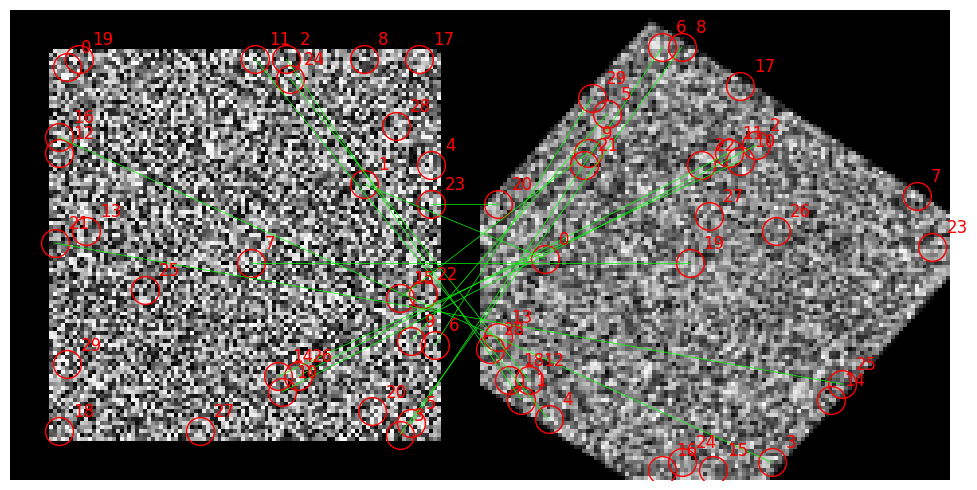

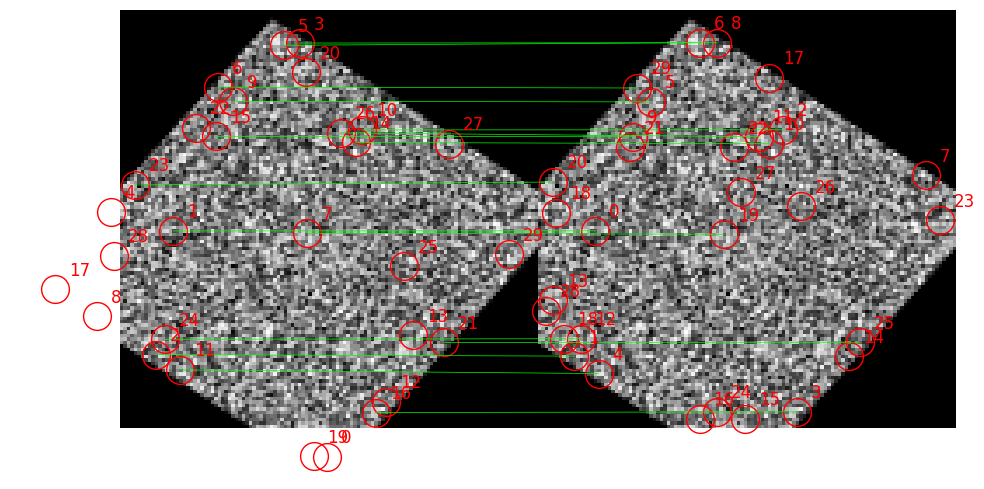

In [11]:
# Exemplo de uso
points1 = transform[0].cpu().numpy()
points2 = batch_points2[0].cpu().numpy()
threshold = 2.0
print("points1.shape:", points1.shape," points2.shape:", points2.shape)
matched = find_best_matching_indices_knn(points1, points2, threshold,k=3)
for (idx1,idx2) in matched:
    print(f"points1[{idx1}] -> points2[{idx2}]")

print(mask_trans.device,transform.device,mask.device)
plot_matches_keypoints(X1[0,0]*mask[0,0], batch_points[0].cpu(), out[0,0]*mask_trans[0,0], batch_points2[0].cpu(),matched)
plot_matches_keypoints(out[0,0]*mask_trans[0,0], transform[0].cpu(), out[0,0]*mask_trans[0,0], batch_points2[0].cpu(),matched)

### Treinamento

In [12]:
import math
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import transforms, InterpolationMode

transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                        shuffle=False, num_workers=2)

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                        download=True, transform=transform)

num_datapoints_to_keep = math.ceil(len(testset) / 2)
indices_to_keep = torch.randperm(num_datapoints_to_keep)[:num_datapoints_to_keep]
reduced_testset = torch.utils.data.Subset(testset, indices_to_keep)
testloader = torch.utils.data.DataLoader(reduced_testset, batch_size=args.batch_size,
                                        shuffle=False, num_workers=2)


In [13]:
from tqdm.notebook import tqdm
import gc
from training import triplet_loss 
from training.tensor_augmetation import shifted_batch_tensor

transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    same_on_batch=True,
    data_keys = ['input','input','input', 'input','keypoints']  # Especificando as chaves de dados
)

# def loss_point(lista_correspondencias,n_pontos=20):
#     acertos = 0
#     qtd_batch =len(lista_correspondencias)
#     margin = n_pontos*0.25
#     for correspondencias in lista_correspondencias:
#         acertos += len(correspondencias)/qtd_batch
#     erros = n_pontos - acertos
#     loss = max(0, erros - acertos + margin)

#     return torch.tensor(loss*qtd_batch, requires_grad=True,dtype=torch.float).to(device)

def loss_point(lista_correspondencias,n_pontos=20):
    acertos = 0
    qtd_batch =len(lista_correspondencias)
    weight = 1
    for correspondencias in lista_correspondencias:
        acertos += (len(correspondencias)/n_pontos)/qtd_batch
    erros = (1 - acertos)
    loss = erros*weight
    return torch.tensor(loss, requires_grad=True,dtype=torch.float).to(device)

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_map,loss_point,device='cpu',transformations=None):
    model.train()
    total_loss = 0.
    t = tqdm(train_loader, desc="Train ")
    batch_i =0
    loss_maps = 0.
    for batch_image, labels in t:
        optimizer.zero_grad()   
        batch_image = batch_image.to(device)
        mask = criar_mascara(batch_image.shape[0],batch_image.shape[-1],args.border_size).to(device)
        features_key_summary,features_ori_summary,batch_points=predict_all_points(batch_image,mask)         
        batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t = transformations(batch_image,mask,features_key_summary,features_ori_summary,batch_points.to(device))# transformar orientacoes e pontos
        features_key_summary_t2,features_ori_summary_t2,batch_points_t2 =predict_all_points(batch_t,mask_t)# prever os pontos da imagem transformada
        lista_correspondencias = find_matching_in_batch(batch_points_t2.cpu(),batch_points_t.cpu(),threshold=THRESHOLD_COLLISION)
        
        batch_image_neg_trans, features_key_summary_neg, features_ori_summary_neg = shifted_batch_tensor(batch_t, features_key_summary_t2,
                                                                    features_ori_summary_t2)  # faz o shift com o comando roll(x,1,0)
        
        loss_maps = loss_map(features_key_summary_t,features_key_summary_t2,features_key_summary_neg)+loss_map(features_ori_summary_t,features_ori_summary_t2,features_ori_summary_neg)
        # loss_maps = loss_map(features_ori_summary_t,features_ori_summary_t2,features_ori_summary_neg)
        loss_col = loss_point(lista_correspondencias,n_pontos=POINTS_LIMIT)
        loss = loss_maps/2 +loss_col        
        # print('loss ',loss,' loss_maps ',loss_maps,' loss_col',loss_col)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        t.set_description("Train Epoch:{} Loss: {:.5f}".format(epoch, loss))
        del features_key_summary,features_ori_summary,batch_points
        del batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t
        del features_key_summary_t2,features_ori_summary_t2,batch_points_t2
        gc.collect()
        torch.cuda.empty_cache()
        batch_i +=1

        
    return total_loss/batch_i

#Create methods to test the model
def test(model,test_loader,loss_map,loss_point,device='cpu',transformations=None):
    model.eval()
    test_loss = 0.
    correct = 0.
    batch_i =0
    loss_maps = 0.
    t = tqdm(test_loader, desc="Test ")
    with torch.no_grad():
        for batch_image, labels in t:
            batch_image = batch_image.to(device)
            mask = criar_mascara(batch_image.shape[0],batch_image.shape[-1],args.border_size).to(device)
            features_key_summary,features_ori_summary,batch_points=predict_all_points(batch_image,mask)         
            batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t = transformations(batch_image,mask,features_key_summary,features_ori_summary,batch_points.to(device))# transformar orientacoes e pontos
            features_key_summary_t2,features_ori_summary_t2,batch_points_t2 =predict_all_points(batch_t,mask_t)# prever os pontos da imagem transformada
            lista_correspondencias = find_matching_in_batch(batch_points_t2.cpu(),batch_points_t.cpu(),threshold=THRESHOLD_COLLISION)
            
            batch_image_neg_trans, features_key_summary_neg, features_ori_summary_neg = shifted_batch_tensor(batch_t, features_key_summary_t2,
                                                                        features_ori_summary_t2)  # faz o shift com o comando roll(x,1,0)
            
            loss_maps = loss_map(features_key_summary_t,features_key_summary_t2,features_key_summary_neg)+loss_map(features_ori_summary_t,features_ori_summary_t2,features_ori_summary_neg)
            # loss_maps = loss_map(features_ori_summary_t,features_ori_summary_t2,features_ori_summary_neg)
            loss_col = loss_point(lista_correspondencias,n_pontos=POINTS_LIMIT)
            loss = loss_maps/2 +loss_col        

            test_loss += loss.item()
            t.set_description("Test Epoch:{} Loss: {:.5f}".format(epoch, loss))
            del features_key_summary,features_ori_summary,batch_points
            del batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t
            del features_key_summary_t2,features_ori_summary_t2,batch_points_t2
            gc.collect()
            torch.cuda.empty_cache()
            batch_i +=1
    return test_loss/batch_i



criterion_d = triplet_loss(is_ssim=args.is_loss_ssim, margim=args.margin_loss)

In [122]:
gc.collect()
torch.cuda.empty_cache()
args.epochs=50
i_epoch = 0
loss = 0
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.50)

best_loss = float('inf')
best_model = None
epochs_without_improvement = 0
    
model=SingularPoints(args).to(device)
print("epoca {} loss {}".format(i_epoch, loss))
for epoch in range(i_epoch, args.epochs):
    # Atualizar a taxa de aprendizado
    if (epoch % 5 == 0) and (epoch != 0):
        scheduler.step()

    running_loss = train_one_epoch(model, trainloader, optimizer=optimizer, loss_map=criterion_d,loss_point=loss_point,device=device,transformations=transformations)
    loss_test = test(model,testloader,loss_map=criterion_d,loss_point=loss_point,device=device,transformations=transformations)
    # Verificar se a perda melhorou
    if loss_test < best_loss:
        best_loss = loss_test
        epochs_without_improvement = 0
        # Salvar o estado do modelo

        best_model = model.state_dict()
    else:
        epochs_without_improvement += 1

    # Verificar a condição de parada
    if epochs_without_improvement == 20:
        print(f"No improvement in loss for {epochs_without_improvement} epochs. Training stopped.")
        break

    print('running_loss: ',running_loss,' loss_test: ',loss_test,' initial_lr:', optimizer.param_groups[0]['initial_lr'], 'lr:', optimizer.param_groups[0]['lr'],' epochs_without_improvement ',epochs_without_improvement)
    
# Carregar a melhor configuração do modelo
model.load_state_dict(best_model)
print(f'Epoch: {epoch}, Best Loss: {best_loss:.4f}')

Namespace(exported=False, num_channels=3, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=50, border_size=10, box_size=21, nms_size=5, img_size=120, batch_size=15, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False, border=21)
epoca 0 loss 0


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2503714596523956  loss_test:  2.2923143555478354  initial_lr: 0.005 lr: 0.005  epochs_without_improvement  0


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2719892000450805  loss_test:  2.255371915421835  initial_lr: 0.005 lr: 0.005  epochs_without_improvement  0


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.218652681392782  loss_test:  2.291947328753588  initial_lr: 0.005 lr: 0.005  epochs_without_improvement  1


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2888957928208744  loss_test:  2.278612395030696  initial_lr: 0.005 lr: 0.005  epochs_without_improvement  2


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.3270972651593826  loss_test:  2.258031895102524  initial_lr: 0.005 lr: 0.005  epochs_without_improvement  3


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.3589788517531227  loss_test:  2.221894723031579  initial_lr: 0.005 lr: 0.0025  epochs_without_improvement  0


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2840546913006725  loss_test:  2.271170584166922  initial_lr: 0.005 lr: 0.0025  epochs_without_improvement  1


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.151863084119909  loss_test:  2.251556498248403  initial_lr: 0.005 lr: 0.0025  epochs_without_improvement  2


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2237871709991905  loss_test:  2.263794528565756  initial_lr: 0.005 lr: 0.0025  epochs_without_improvement  3


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.338707364657346  loss_test:  2.2306259480918325  initial_lr: 0.005 lr: 0.0025  epochs_without_improvement  4


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2652470504536346  loss_test:  2.236758510077872  initial_lr: 0.005 lr: 0.00125  epochs_without_improvement  5


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.3212897935334373  loss_test:  2.279975184580175  initial_lr: 0.005 lr: 0.00125  epochs_without_improvement  6


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.228438906809863  loss_test:  2.286770514744084  initial_lr: 0.005 lr: 0.00125  epochs_without_improvement  7


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.326091550728854  loss_test:  2.2885444106125252  initial_lr: 0.005 lr: 0.00125  epochs_without_improvement  8


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.25744994948892  loss_test:  2.254587292089695  initial_lr: 0.005 lr: 0.00125  epochs_without_improvement  9


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2919800228932323  loss_test:  2.306506308695165  initial_lr: 0.005 lr: 0.000625  epochs_without_improvement  10


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.177362776854459  loss_test:  2.2276037855846127  initial_lr: 0.005 lr: 0.000625  epochs_without_improvement  11


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2194514993359062  loss_test:  2.2896443239072473  initial_lr: 0.005 lr: 0.000625  epochs_without_improvement  12


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.370741605758667  loss_test:  2.2056390023813015  initial_lr: 0.005 lr: 0.000625  epochs_without_improvement  0


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.316003809956943  loss_test:  2.2699591060964073  initial_lr: 0.005 lr: 0.000625  epochs_without_improvement  1


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.3251264621229732  loss_test:  2.282403588294983  initial_lr: 0.005 lr: 0.0003125  epochs_without_improvement  2


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.330196433207568  loss_test:  2.2143067493671325  initial_lr: 0.005 lr: 0.0003125  epochs_without_improvement  3


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.313488420318155  loss_test:  2.242243938911252  initial_lr: 0.005 lr: 0.0003125  epochs_without_improvement  4


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.3093912338509277  loss_test:  2.3172953245116443  initial_lr: 0.005 lr: 0.0003125  epochs_without_improvement  5


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.3132506766740013  loss_test:  2.25632580547798  initial_lr: 0.005 lr: 0.0003125  epochs_without_improvement  6


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.302255020422094  loss_test:  2.2626684473782053  initial_lr: 0.005 lr: 0.00015625  epochs_without_improvement  7


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.216850640142665  loss_test:  2.266301201029522  initial_lr: 0.005 lr: 0.00015625  epochs_without_improvement  8


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.1510772775201237  loss_test:  2.2222754426118803  initial_lr: 0.005 lr: 0.00015625  epochs_without_improvement  9


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.322578828124439  loss_test:  2.2586388436759393  initial_lr: 0.005 lr: 0.00015625  epochs_without_improvement  10


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.3332407544640934  loss_test:  2.2857219114536194  initial_lr: 0.005 lr: 0.00015625  epochs_without_improvement  11


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.3069725176867317  loss_test:  2.2515943690044122  initial_lr: 0.005 lr: 7.8125e-05  epochs_without_improvement  12


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2957310027935924  loss_test:  2.2605762545655415  initial_lr: 0.005 lr: 7.8125e-05  epochs_without_improvement  13


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2698794743594  loss_test:  2.2033861881349144  initial_lr: 0.005 lr: 7.8125e-05  epochs_without_improvement  0


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.3342769496581135  loss_test:  2.2286096380978098  initial_lr: 0.005 lr: 7.8125e-05  epochs_without_improvement  1


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.285704582929611  loss_test:  2.2842504291999632  initial_lr: 0.005 lr: 7.8125e-05  epochs_without_improvement  2


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2842623521299923  loss_test:  2.2639198349743355  initial_lr: 0.005 lr: 3.90625e-05  epochs_without_improvement  3


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.294672000057557  loss_test:  2.2921305854146072  initial_lr: 0.005 lr: 3.90625e-05  epochs_without_improvement  4


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2434246434884915  loss_test:  2.29052861143903  initial_lr: 0.005 lr: 3.90625e-05  epochs_without_improvement  5


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2248103881583496  loss_test:  2.2933833023396932  initial_lr: 0.005 lr: 3.90625e-05  epochs_without_improvement  6


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.246088774765239  loss_test:  2.2937129003245658  initial_lr: 0.005 lr: 3.90625e-05  epochs_without_improvement  7


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2606276694466088  loss_test:  2.2336614399421504  initial_lr: 0.005 lr: 1.953125e-05  epochs_without_improvement  8


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2604219878421112  loss_test:  2.2471876406088107  initial_lr: 0.005 lr: 1.953125e-05  epochs_without_improvement  9


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2079998745637783  loss_test:  2.2565319730014335  initial_lr: 0.005 lr: 1.953125e-05  epochs_without_improvement  10


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2902956815326916  loss_test:  2.243771487910573  initial_lr: 0.005 lr: 1.953125e-05  epochs_without_improvement  11


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.273875069968841  loss_test:  2.228207581217696  initial_lr: 0.005 lr: 1.953125e-05  epochs_without_improvement  12


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.2340251908582798  loss_test:  2.2130819913817614  initial_lr: 0.005 lr: 9.765625e-06  epochs_without_improvement  13


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.219976667095633  loss_test:  2.2480491469546062  initial_lr: 0.005 lr: 9.765625e-06  epochs_without_improvement  14


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.324519157409668  loss_test:  2.265651419686108  initial_lr: 0.005 lr: 9.765625e-06  epochs_without_improvement  15


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.26901656739852  loss_test:  2.2712782412040524  initial_lr: 0.005 lr: 9.765625e-06  epochs_without_improvement  16


Train :   0%|          | 0/68 [00:00<?, ?it/s]

Test :   0%|          | 0/205 [00:00<?, ?it/s]

running_loss:  2.259918673950083  loss_test:  2.2703528398420754  initial_lr: 0.005 lr: 9.765625e-06  epochs_without_improvement  17
Epoch: 49, Best Loss: 2.2034


In [15]:
import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    print(f"Model loaded from {filepath}")
    

# teste = model.copy()
path_siamese = './data/models/sp1.pth'
# save_model(model,path_siamese)


In [88]:
path_siamese = './data/models/sp_50.pth'
model = SingularPoints(args=args).to(device)
load_model(model,path_siamese)


Namespace(exported=False, num_channels=3, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=15, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)
Model loaded from ./data/models/sp_50.pth


In [89]:
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape,labels.shape)
img = img.to(device)
model.eval()
with torch.no_grad():
  mask = criar_mascara(img.shape[0],img.shape[-1],args.border_size).to(device)
  features_key_summary,features_ori_summary,batch_points=predict_all_points(img,mask)         
  batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t = transformations(img,mask,features_key_summary,features_ori_summary,batch_points.to(device))# transformar orientacoes e pontos
  features_key_summary_t2,features_ori_summary_t2,batch_points_t2 =predict_all_points(batch_t,mask_t)# prever os pontos da imagem transformada
  


torch.Size([15, 3, 120, 120]) torch.Size([15])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


total de pontos 450 acertos 355 -- %78.88888888888889
torch.Size([15, 30, 2]) torch.Size([15, 30, 2])
points1[0] -> points2[7]
points1[1] -> points2[5]
points1[2] -> points2[11]
points1[3] -> points2[1]
points1[4] -> points2[3]
points1[5] -> points2[22]
points1[6] -> points2[13]
points1[7] -> points2[10]
points1[8] -> points2[27]
points1[9] -> points2[20]
points1[10] -> points2[14]
points1[11] -> points2[2]
points1[12] -> points2[12]
points1[13] -> points2[18]
points1[14] -> points2[17]
points1[15] -> points2[8]
points1[16] -> points2[23]
points1[19] -> points2[19]
points1[20] -> points2[26]
points1[28] -> points2[25]
qtd acertos 20


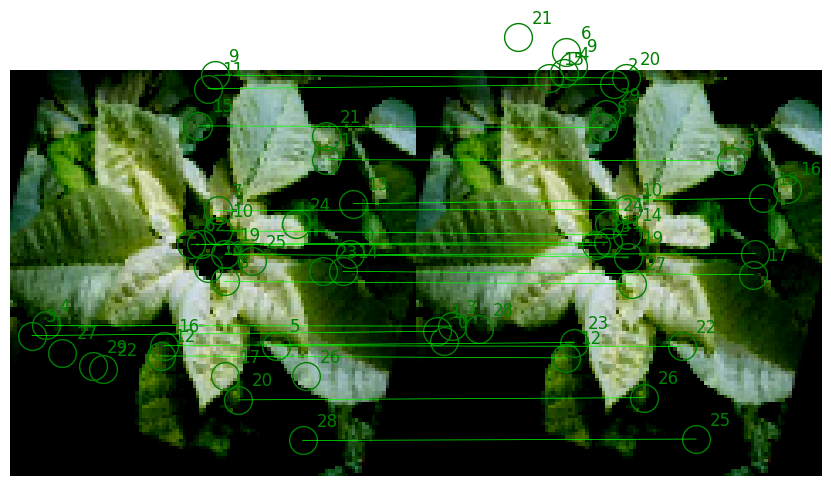

tensor(0.2111, device='cuda:0', grad_fn=<ToCopyBackward0>)

In [229]:
INDEX =0
lista_correspondencias = find_matching_in_batch(batch_points_t2.cpu(),batch_points_t.cpu(),threshold=4)  
acertos = 0
for correspondencias in lista_correspondencias:
  acertos +=len(correspondencias)

q,p,_ = batch_points_t.shape
total = q*p
print("total de pontos {} acertos {} -- %{}".format(total,acertos,acertos*100/total))

print(batch_points_t2.shape,batch_points_t.shape)
for (idx1,idx2) in lista_correspondencias[INDEX]:
    print(f"points1[{idx1}] -> points2[{idx2}]")
print(f"qtd acertos {len(lista_correspondencias[INDEX])}")
plot_matches_keypoints(batch_t[INDEX].permute(1,2,0), batch_points_t2[INDEX].cpu(), batch_t[INDEX].permute(1,2,0), batch_points_t[INDEX].cpu(),lista_correspondencias[INDEX])

loss_col = loss_point(lista_correspondencias,n_pontos=POINTS_LIMIT)
loss_col

In [169]:
# iterator=iter(testloader)
# img,labels = next(iterator)
# print(img.shape,labels.shape)
img = img.to(device)
model.eval()
with torch.no_grad():
  mask = criar_mascara(img.shape[0],img.shape[-1],args.border_size).to(device)
  features_key,features_ori,batch_points=predict_all_descritor(img,mask)      
  batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t = transformations(img,mask,features_key_summary,features_ori_summary,batch_points.to(device))# transformar orientacoes e pontos
  features_key_t2,features_ori_t2,batch_points_t2 =predict_all_descritor(batch_t,mask_t)# prever os pontos da imagem transformada
  


In [233]:
import numpy as np
from skimage import draw

    
def get_circle_by_point(imagem,point=(0,0),radius=30):
  x, y =int(point[0]),int(point[1])
  # Criar máscara circular
  linhas, colunas = imagem.shape[-2:]
  mascara = np.zeros((linhas, colunas), dtype=np.uint8)
  rr, cc = draw.disk((x, y), radius, shape=(linhas, colunas))
  mascara[rr, cc] = 1
  # Aplicar máscara à imagem para obter a subimagem do círculo
  subimagem = imagem * mascara
  # Obter coordenadas do retângulo delimitador
  min_row, min_col, max_row, max_col = rr.min(), cc.min(), rr.max(), cc.max()

  return subimagem[:,min_row:max_row,min_col:max_col]

import torch
import torch.nn as nn

# Cria uma camada de pooling global average
global_avg_pool = nn.AdaptiveAvgPool2d(1)
global_max_pool = nn.AdaptiveMaxPool2d(1)
# Aplica o pooling global average no tensor de entrada
# output = global_avg_pool(x)

torch.Size([15, 8, 120, 120]) <class 'torch.Tensor'> torch.Size([15, 36, 120, 120]) torch.Size([15, 30, 2])
tensor([0.5062, 0.0201, 0.3438, 0.2989, 0.0819, 0.5107, 0.4264, 0.3487])
tensor([1.4408, 0.3545, 2.8688, 2.0779, 0.9542, 1.6156, 2.6346, 1.2970])
tensor([0.0178, 0.0185, 0.0178, 0.0170, 0.0172, 0.0194, 0.0237, 0.0262, 0.0257,
        0.0281, 0.0323, 0.0366, 0.0368, 0.0345, 0.0310, 0.0277, 0.0266, 0.0263,
        0.0257, 0.0246, 0.0235, 0.0225, 0.0218, 0.0225, 0.0237, 0.0247, 0.0256,
        0.0264, 0.0267, 0.0270, 0.0261, 0.0248, 0.0219, 0.0194, 0.0180, 0.0176])
tensor([0.0871, 0.0840, 0.0892, 0.0771, 0.0697, 0.0946, 0.1172, 0.1607, 0.1204,
        0.1282, 0.1740, 0.1982, 0.1901, 0.1747, 0.1509, 0.1007, 0.0893, 0.1210,
        0.1072, 0.0916, 0.1092, 0.0937, 0.0789, 0.0537, 0.0732, 0.0923, 0.0964,
        0.0996, 0.0828, 0.0894, 0.0925, 0.1487, 0.0781, 0.0928, 0.1052, 0.1007])


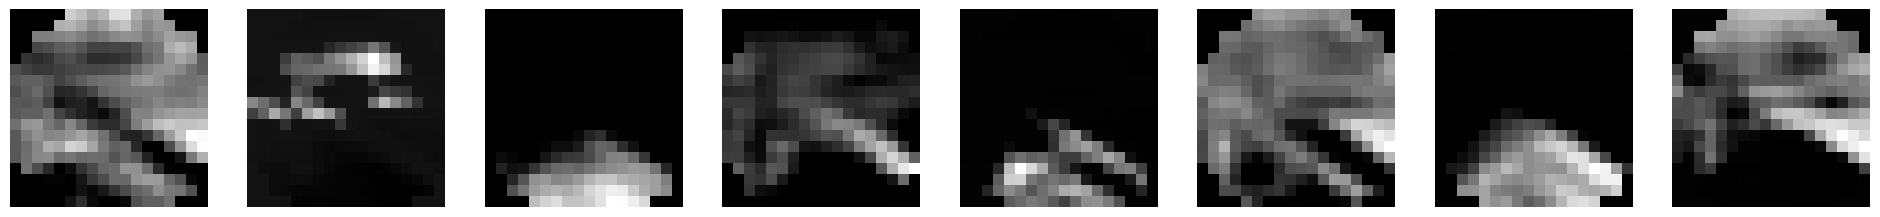

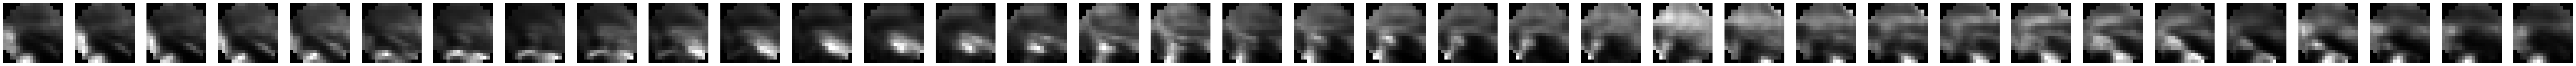

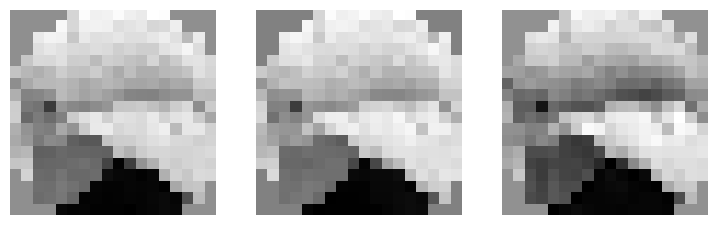

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


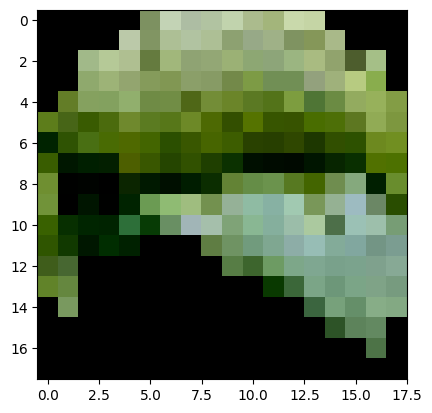

In [245]:
PT_IDX = 22
RADIUS = 10
print(features_key.shape,type(features_key),features_ori.shape,batch_points.shape)

sub_key = get_circle_by_point(features_key[INDEX].cpu(),point=(batch_points[INDEX,PT_IDX,1],batch_points[INDEX,PT_IDX,0]),radius=RADIUS)
sub_ori = get_circle_by_point(features_ori[INDEX].cpu(),point=(batch_points[INDEX,PT_IDX,1],batch_points[INDEX,PT_IDX,0]),radius=RADIUS)
subimagem = get_circle_by_point(img[INDEX].cpu(),point=(batch_points[INDEX,PT_IDX,1],batch_points[INDEX,PT_IDX,0]),radius=RADIUS)

print(global_avg_pool(sub_key).squeeze())
print(global_max_pool(sub_key).squeeze())
print(global_avg_pool(sub_ori).squeeze())
print(global_max_pool(sub_ori).squeeze())

plot_images_side_by_side(sub_key.cpu())
plot_images_side_by_side(sub_ori.cpu())
plot_images_side_by_side(subimagem.cpu())

plt.imshow(subimagem.cpu().permute(1,2,0))
plt.show()

torch.Size([15, 8, 120, 120]) torch.Size([15, 36, 120, 120]) torch.Size([15, 30, 2])
tensor([0.4971, 0.0212, 0.2995, 0.2889, 0.0841, 0.5081, 0.3798, 0.3602])
tensor([1.3764, 0.3643, 2.7026, 1.9088, 1.0956, 1.5870, 2.4388, 1.3926])
tensor([0.0192, 0.0181, 0.0178, 0.0195, 0.0226, 0.0243, 0.0241, 0.0269, 0.0313,
        0.0357, 0.0365, 0.0352, 0.0319, 0.0283, 0.0269, 0.0271, 0.0269, 0.0257,
        0.0243, 0.0233, 0.0224, 0.0225, 0.0232, 0.0238, 0.0245, 0.0255, 0.0259,
        0.0264, 0.0252, 0.0236, 0.0215, 0.0196, 0.0187, 0.0186, 0.0191, 0.0200])
tensor([0.0888, 0.0832, 0.0677, 0.0662, 0.1179, 0.1550, 0.0952, 0.1211, 0.1673,
        0.1899, 0.1930, 0.1869, 0.1595, 0.1160, 0.0734, 0.1024, 0.1076, 0.0864,
        0.0924, 0.1122, 0.0764, 0.0649, 0.0565, 0.0721, 0.0843, 0.0915, 0.0841,
        0.0926, 0.0892, 0.0829, 0.0728, 0.0825, 0.0935, 0.0946, 0.0908, 0.0891])


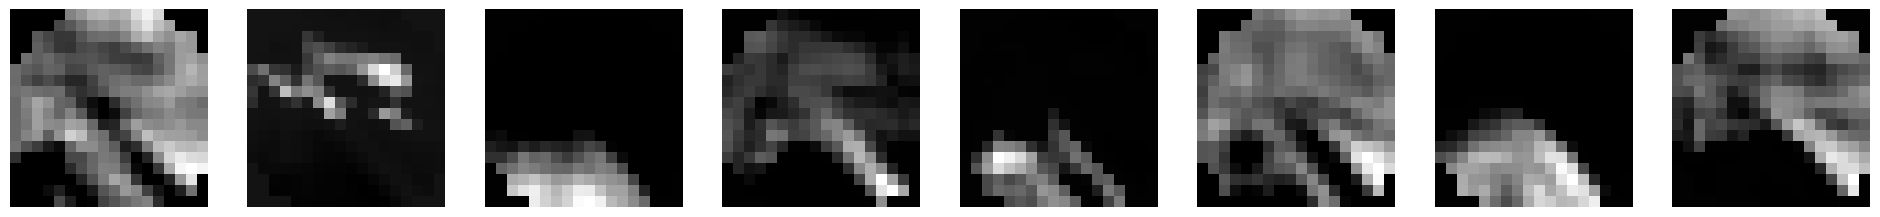

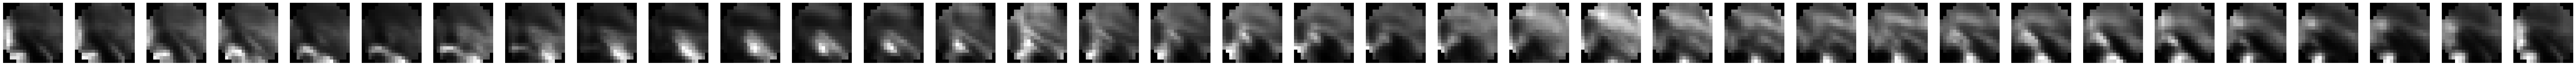

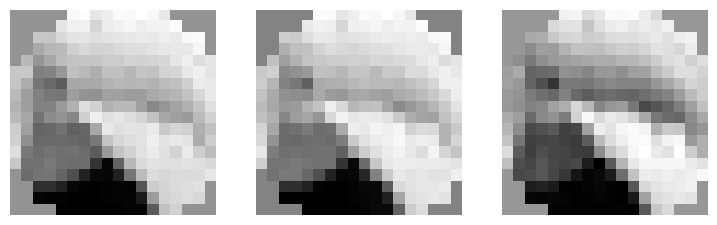

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


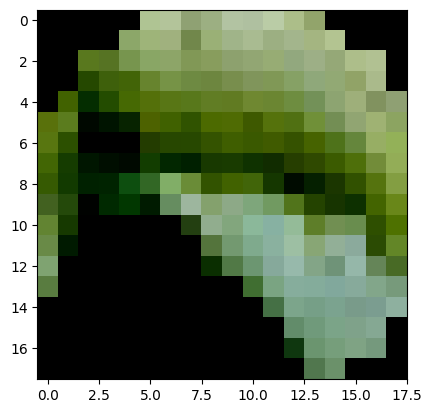

In [246]:
PT_IDX = 5
print(features_key_t2.shape,features_ori_t2.shape,batch_points_t2.shape)

sub_key = get_circle_by_point(features_key_t2[INDEX].cpu(),point=(batch_points_t2[INDEX,PT_IDX,1],batch_points_t2[INDEX,PT_IDX,0]),radius=RADIUS)
sub_ori = get_circle_by_point(features_ori_t2[INDEX].cpu(),point=(batch_points_t2[INDEX,PT_IDX,1],batch_points_t2[INDEX,PT_IDX,0]),radius=RADIUS)
subimagem = get_circle_by_point(batch_t[INDEX].cpu(),point=(batch_points_t2[INDEX,PT_IDX,1],batch_points_t2[INDEX,PT_IDX,0]),radius=RADIUS)

print(global_avg_pool(sub_key).squeeze())
print(global_max_pool(sub_key).squeeze())
print(global_avg_pool(sub_ori).squeeze())
print(global_max_pool(sub_ori).squeeze())

plot_images_side_by_side(sub_key.cpu())
plot_images_side_by_side(sub_ori.cpu())
plot_images_side_by_side(subimagem.cpu())

plt.imshow(subimagem.cpu().permute(1,2,0))
plt.show()